In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tqdm
import math

# Prepare MNIST dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter samples for classes 0, 1, 2
class_indices = [0, 1, 2]
filtered_data = [(image, label) for image, label in train_dataset if label in class_indices]

# Create new dataset containing only samples from classes 0, 1, 2
class FilteredMNIST(Dataset):
    def __init__(self, filtered_data):
        self.filtered_data = filtered_data

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        return self.filtered_data[idx]

# Create new DataLoader
batch_size = 128
train_dataset = FilteredMNIST(filtered_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 43.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.59MB/s]


In [23]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, height * width).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(batch_size, channels, height, width)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64, time_dim=256):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )
        self.time_dim = time_dim
        
        # Encoder
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128, time_dim)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256, time_dim)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)

        # Bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        # Decoder
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, t):
        # Time embedding
        t = self.time_mlp(t)

        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        # Decoder
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)

        return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, base_channels=64, time_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
training_steps = 10_000
pbar = tqdm.tqdm(range(training_steps))
loss_min = 10000000

for i in pbar:
    x1, _ = next(iter(train_loader))
    x1 = x1.to(device)
    x0 = torch.randn_like(x1).to(device)
    target = x1 - x0

    t = torch.rand(x1.size(0)).to(device)
    xt = (1 - t[:, None, None, None]) * x0 + t[:, None, None, None] * x1
    pred = model(xt, t)

    loss = ((target - pred)**2).mean()

    # Save the best weight
    if loss < loss_min:
        loss_min = loss
        torch.save(model.state_dict(), "best_model.pth")

    # Update model weights
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_postfix(loss=loss.item())

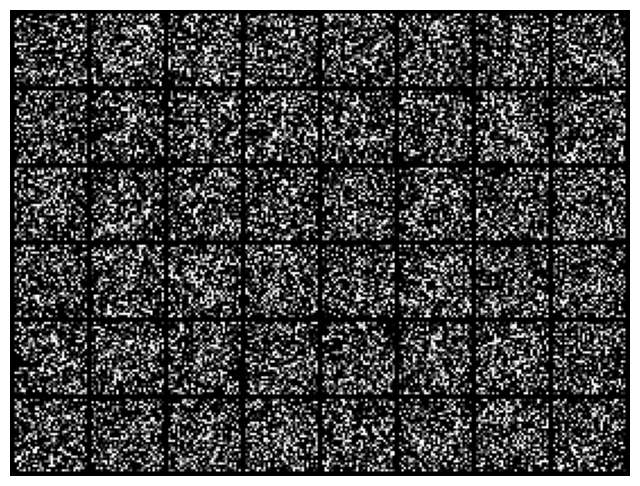

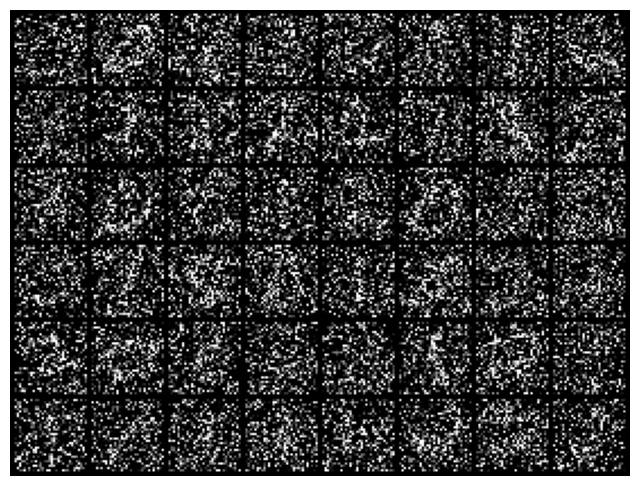

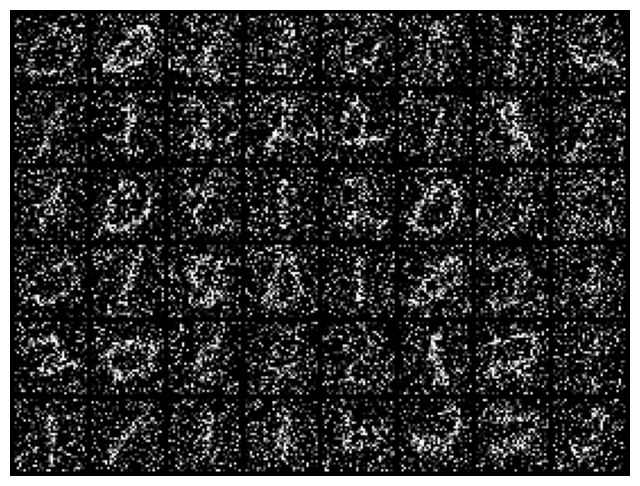

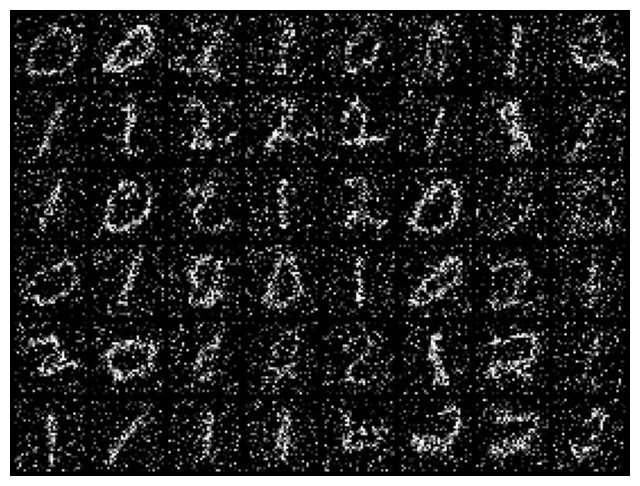

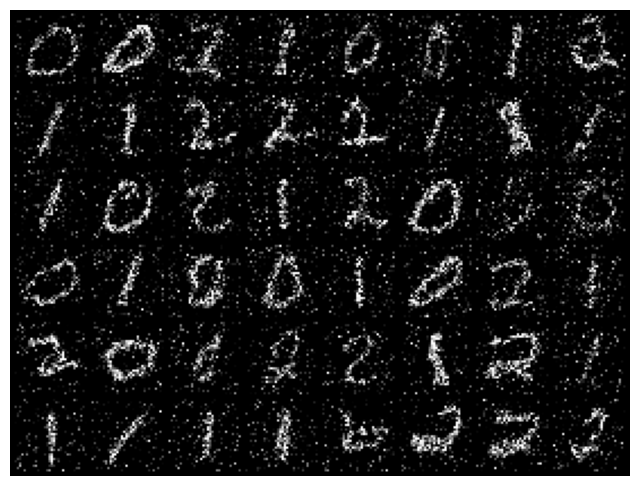

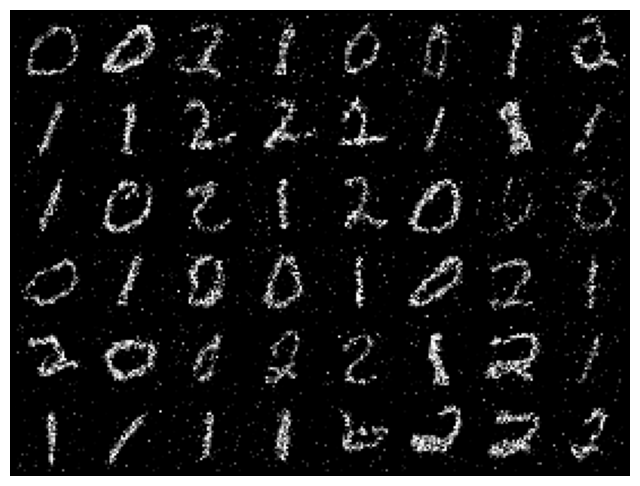

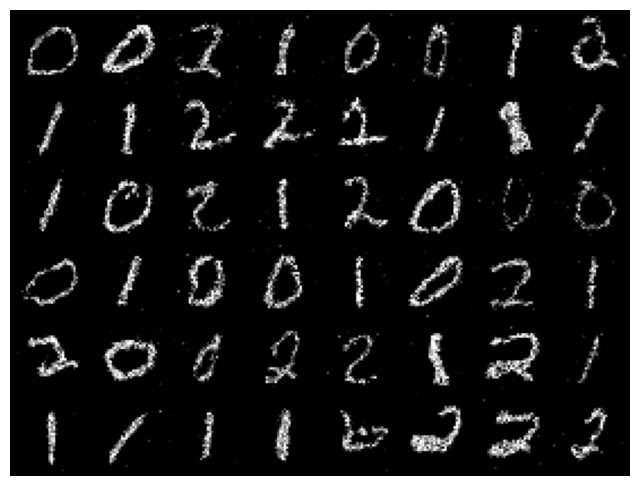

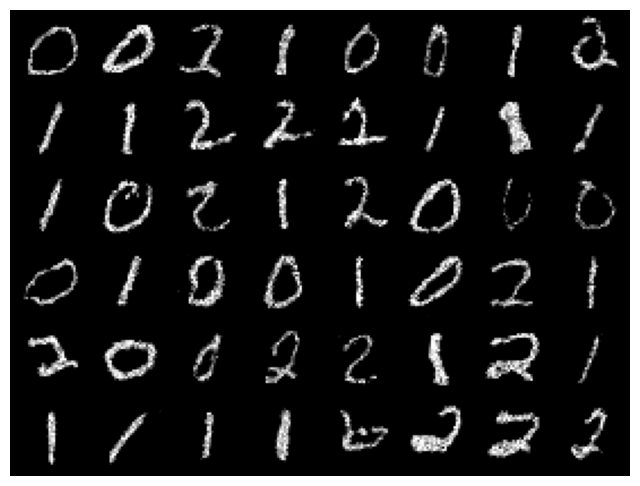

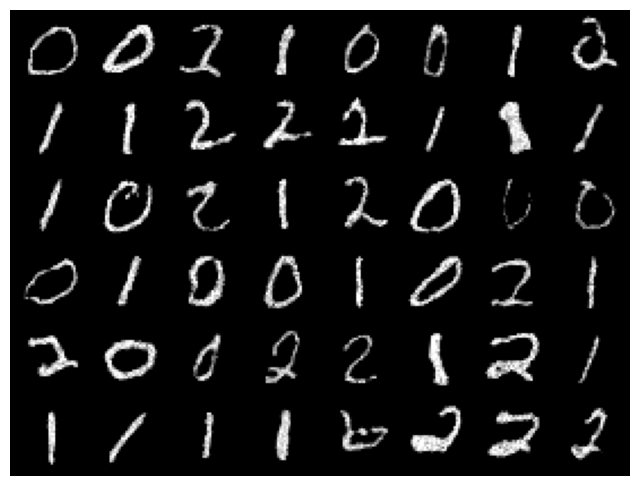

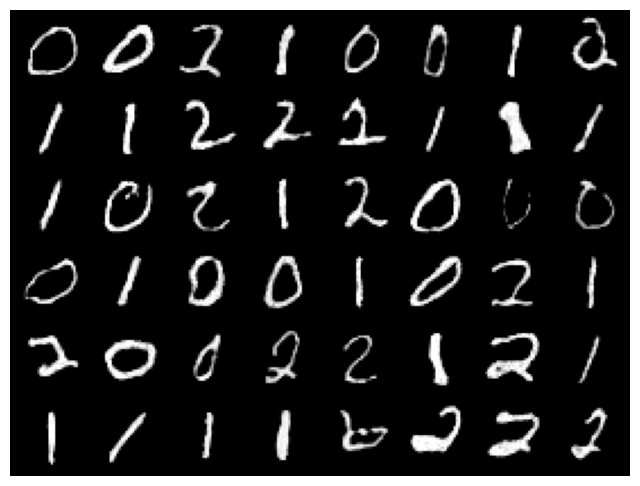

Final sampling image saved as 'final_sampling_image.png'


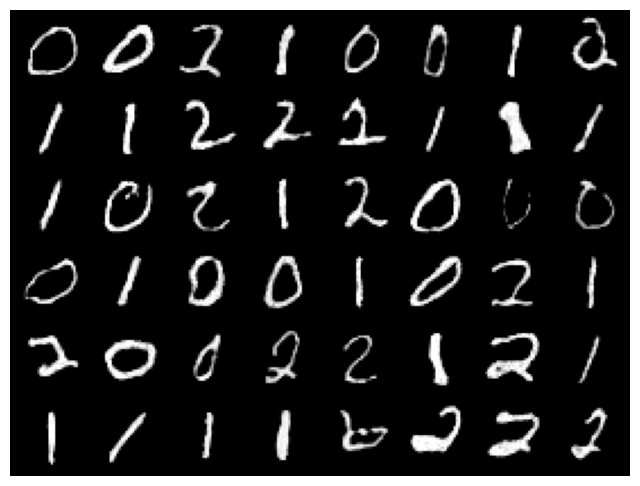

In [28]:
# Sampling from noise
torch.manual_seed(1234)

# Load model
model = UNet(in_channels=1, out_channels=1, base_channels=64, time_dim=256)
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
model.eval()

with torch.no_grad():
    xt = torch.randn(48, 1, 32, 32).to(device) 
    steps = 1000
    plot_every = 100
    final_image = None

    for i, t in enumerate(torch.linspace(1, 0, steps), start=1):
        # Generate new images
        pred = model(xt, t.expand(xt.size(0)).to(device))
        xt = xt + (1 / steps) * pred

        # Display generated images every plot_every steps (100 steps)
        if i % plot_every == 0:
            grid_img = torchvision.utils.make_grid(xt, nrow=8, padding=2)
            final_image = grid_img.permute(1, 2, 0).cpu().numpy()
            plt.figure(figsize=(8, 8))
            plt.imshow(final_image, cmap="gray")
            plt.axis('off')
            plt.show()